In [1]:
import pandas as pd
import numpy as np

In [2]:
DATA_PATH = 'data/vehicle_dataset_public/'
DATA_PROC_PATH = 'data/vehicle_proccessed/'

TAGS_FEATURES = ['fuelLevel', 'ingection', 'speedAndHeight', 'tachometer']
TAGS_TARGET = ['refueling2']
TAGS = TAGS_FEATURES + TAGS_TARGET

TIME_COLUMNS = ['DTIME', 'STARTDATE', 'ENDDATE']
FLOAT_COLUMNS = ['BEVALUE', 'SPEED', 'HEIGHT']

VEHICLE_IDS = [1, 3, 5, 19, 28]

In [3]:
from functools import reduce

# Словарь, состоящий из dataframe'ов для каждого признака
def dict_df_vehicle_i(i):
    dict_df_vehicle = {}
    for tag in TAGS:
        df = pd.read_csv(DATA_PATH +
                         f'vehicle{i}_{tag}_public.csv', sep=';')
        for col in FLOAT_COLUMNS:
            if col in df.columns and df[col].dtype == 'object':
                df[col] = df[col].str.replace(',','.').astype(float)
        df.rename(columns={'BEVALUE': tag}, inplace=True)

        for time_col in TIME_COLUMNS:
            if time_col in df.columns:
                df[time_col] = pd.to_datetime(df[time_col])

        dict_df_vehicle[tag] = df

    return dict_df_vehicle

# Объединение всех "исходных" признаков из словаря dataframe'ов
# в один dataframe
def df_summary(dict_df, merge_how='outer'):
    df_to_merge = [dict_df[name] for name in TAGS_FEATURES]

    df_res = reduce(lambda left, right: pd.merge(left, right, how=merge_how, on='DTIME'),
                    df_to_merge)
    df_res.columns = df_res.columns.str.lower()

    return df_res

In [4]:
# экспоненциальное сглаживание
def exp_smoothing(arr, alpha=0.8):
    if len(arr) < 1:
        return np.array([])
    newArr = [arr[0]]
    for a in arr[1:]:
        newArr.append(newArr[-1] * alpha + a * (1-alpha))
    return np.array(newArr)

In [5]:
import matplotlib.pyplot as plt

In [6]:
# возвращает два списка: интервалы роста и интервалы не роста
# minGrowthAmount - минимальное приращение, считаемое ростом

def find_growth_intervals(arr, minGrowthAmount):
    growthIntervals = []
    nonGrowthIntervals = []
    
    growing = False
    
    currInterval = [0, 1]
    
    for i in range(1, len(arr)-1):

        if arr[i] - arr[i-1] < 0:
            if growing:
                growthAmount = arr[currInterval[1]-1] - arr[currInterval[0]]
                if growthAmount >= minGrowthAmount:
                    growthIntervals.append(currInterval)
                    currInterval = [i, i+1]
            growing = False
            
        else:
            if not growing:
                nonGrowthIntervals.append(currInterval)
                currInterval = [i, i+1]
            growing = True
            
        currInterval[1] += 1
    
    
    if currInterval[0] < len(arr)-2:
        currInterval = [currInterval[0], len(arr)-2]
        if  growing:
            growthIntervals.append(currInterval)
        else:
            nonGrowthIntervals.append(currInterval)
        
    return growthIntervals, nonGrowthIntervals

In [7]:
def get_time_intervals(time_series, max_dtime_hours):
    intervals = []
    
    start = 0
    
    for i in range(1, len(time_series)):
        
        dtime_hours = (time_series.iloc[i] - time_series.iloc[i-1]).total_seconds() / 3600
        
        if dtime_hours > max_dtime_hours:
            intervals.append((start, i))
            start = i + 1
    
    if len(time_series) - 1 - start > 0:
        intervals.append((start, i-1))
    
    return intervals

def timedelta_to_hours(timedelta):
    return np.dot(timedelta.dt.components, [24, 1, 1/60, 1/(60**2), 1/(60**3), 1/(60**4), 1/(60**5)])

def approximate_derivative(time, value):
    timeShifted = np.full(len(time), np.nan)
    timeShifted[1:] = time[:-1]
    timeShifted = pd.to_datetime(timeShifted)
    timeDelta = timedelta_to_hours(time - timeShifted)
    
    valueShifted = np.full(len(value), np.nan)
    valueShifted[1:] = value[:-1]
    
    valueDelta = value - valueShifted

    return valueDelta / timeDelta

# был ли слив на интервале
def is_theft(df, lph_threshold, delta_threshold):
    if len(df) < 2:
        return False
    
    dtime_hours = (df['dtime'].iloc[-1] - df['dtime'].iloc[0]).total_seconds() / 3600
    dlevel = df['fuellevel'].iloc[-1] - df['fuellevel'].iloc[0]
    interval_lph = dlevel / dtime_hours

    return interval_lph < lph_threshold and dlevel < delta_threshold

def process_interval(df, lph_threshold, delta_threshold):
    
    refuelings = []
    thefts = []
    
    smoothed_fuel_level = exp_smoothing(df['fuellevel'].values, 0.9)
    growth_intervals, nongrowth_intervals = find_growth_intervals(smoothed_fuel_level, 1)
    
    for left, right in growth_intervals:
        refuelings.append((left, right))
        
    for left, right in nongrowth_intervals:
         if is_theft(df.iloc[left:right], lph_threshold, delta_threshold):
                thefts.append((left, right))
                
    return refuelings, thefts

In [9]:
# максимальное расстояние между записями для того, чтобы они принадлежали одному временному интервалу
MAX_DTIME_HOURS = 1 

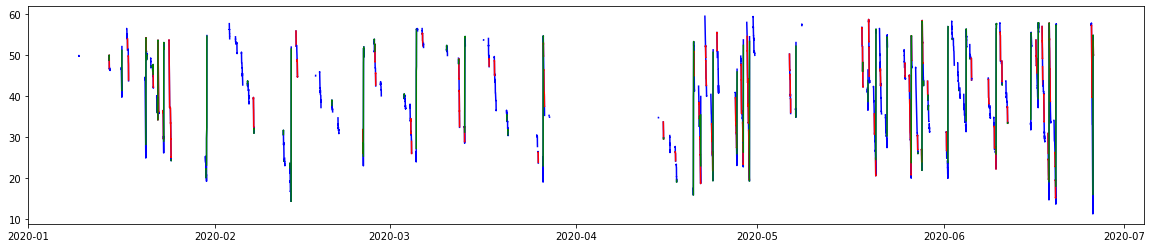

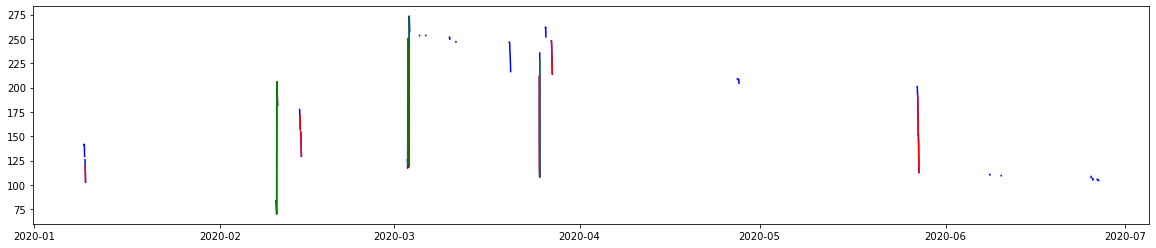

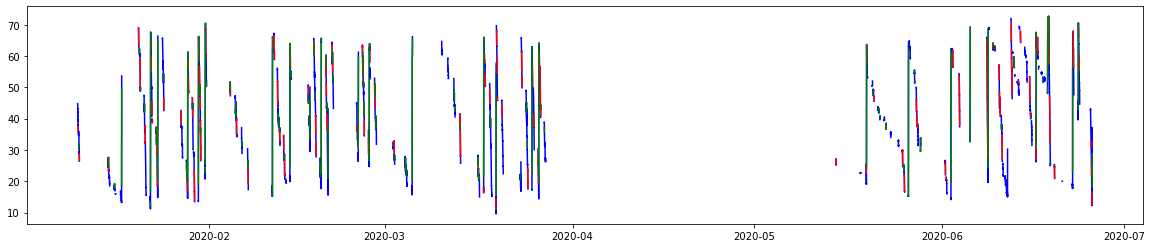

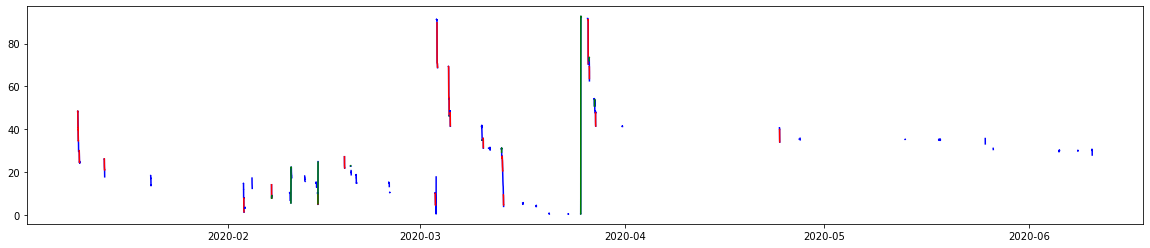

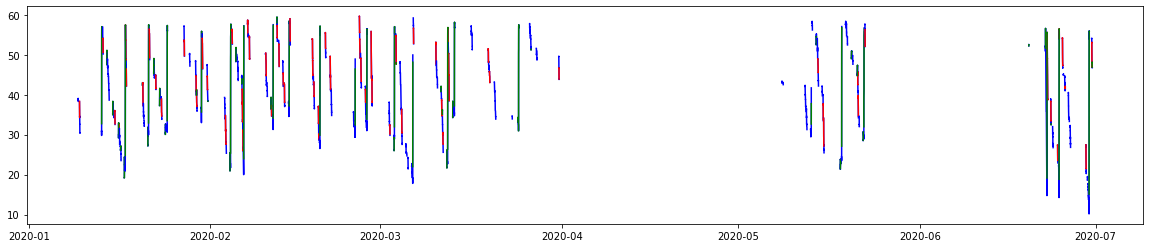

In [11]:
# синий - штатный расход
# красный - слив
# зеленый - заправка

for vehicle_id in VEHICLE_IDS:
    dict_df = dict_df_vehicle_i(vehicle_id)
    df_sum = df_summary(dict_df, merge_how='inner')
    df_sum = df_sum.loc[df_sum['fuellevel']!=0]

    max_fuel_level = df_sum['fuellevel'].max()

    time_intervals = get_time_intervals(df_sum['dtime'], max_dtime_hours=MAX_DTIME_HOURS)

    plt.figure(figsize=(20, 4))

    for left, right in time_intervals:
        interval_df = df_sum.iloc[left:right]

        smoothed_fuel_level = exp_smoothing(interval_df['fuellevel'].values, 0.9)
        
        
        # параметры, по которым определяется, был ли слив
        
        # минимальное изменение уровня топлива за 
        # весь интервал (для того, чтобы был задетекчен слив)
        delta_threshold = -max_fuel_level * 0.05 
        # минимальная скорость изменения топлива
        lph_threshold = -max_fuel_level / 60 

        refuelings, thefts = process_interval(interval_df, lph_threshold, delta_threshold)

        plt.plot(interval_df['dtime'], smoothed_fuel_level, c='b')

        for left, right in thefts:
            # сливы
            plt.plot(interval_df['dtime'].iloc[left:right], smoothed_fuel_level[left:right], c='r')

        for left, right in refuelings:
            # заправки
            plt.plot(interval_df['dtime'].iloc[left:right], smoothed_fuel_level[left:right], c='g')

